In [1]:
import random
import numpy as np
import sys
import pandas as pd

In [2]:
constants = {
    "BASEFEE_MAX_CHANGE_DENOMINATOR": 8,
    "TARGET_GAS_USED": 10000000,
    "MAX_GAS_EIP1559": 20000000,
    "EIP1559_DECAY_RANGE": 800000,
    "EIP1559_GAS_INCREMENT_AMOUNT": 10,
    "INITIAL_BASEFEE": 1 * (10 ** 9),
    "PER_TX_GASLIMIT": 8000000,
    "SIMPLE_TRANSACTION_GAS": 21000,
}

rng = np.random.default_rng()

In [3]:
def get_basefee_bounds(basefee, blocks):
    # We want to know how high/low the basefee can be after `blocks` steps, starting from `basefee`
    lb = basefee * (1 - 1.0 / constants["BASEFEE_MAX_CHANGE_DENOMINATOR"])
    ub = basefee * (1 + 1.0 / constants["BASEFEE_MAX_CHANGE_DENOMINATOR"])
    return { "lb": lb, "ub": ub }

Define transaction classes, for EIP 1559 and the escalator (also floating escalator). Transaction API:

- `gas_price(params)`: what the user pays
- `tip(params)`: what the miner gets
- `is_valid(params)`: can the transaction be included given `params`?

In [4]:
class Transaction:
    
    def __init__(self, sender, params, gas_used = constants["SIMPLE_TRANSACTION_GAS"]):
        self.sender = sender
        self.start_block = params["start_block"]
        self.gas_used = gas_used
        self.tx_hash = rng.bytes(8)
    
class Tx1559(Transaction):
    
    def __init__(self, sender, params, gas_used = constants["SIMPLE_TRANSACTION_GAS"]):
        super().__init__(sender, params, gas_used = gas_used)
        
        self.gas_premium = params["gas_premium"]
        self.max_fee = params["max_fee"]
        
    def __str__(self):
        return f"1559 Transaction {self.tx_hash.hex()}: max_fee {self.max_fee}, gas_premium {self.gas_premium}"
    
    def is_valid(self, params):
        basefee = params["basefee"]
        return self.max_fee >= basefee
    
    def gas_price(self, params):
        # What the user pays
        basefee = params["basefee"]
        return min(self.max_fee, basefee + self.gas_premium)
    
    def tip(self, params):
        # What the miner gets
        basefee = params["basefee"]
        return self.gas_price(params) - basefee
    
class TxEscalator(Transaction):
    
    def __init__(self, sender, params, gas_used = constants["SIMPLE_TRANSACTION_GAS"]):
        super().__init__(sender, params, gas_used = gas_used)
        
        self.max_block = params["max_block"]
        self.start_premium = params["start_premium"]
        self.max_premium = params["max_premium"]
        
    def __str__(self):
        return f"Escalator Transaction {self.tx_hash.hex()}: start block {self.start_block}, " + \
                f"max block {self.max_block}, start premium {self.start_premium}, max premium {self.max_premium}"
    
    def is_valid(self, params):
        current_block = params["current_block"]
        return self.start_block <= current_block and current_block <= self.max_block
    
    def gas_price(self, params):
        # What the user pays
        current_block = params["current_block"]
        fraction_elapsed = (current_block - self.start_block) / (self.max_block - self.start_block)
        return self.start_premium + fraction_elapsed * (self.max_premium - self.start_premium)
    
    def tip(self, params):
        # What the miner gets
        # In the escalator, miner gets the whole gas_price
        return self.gas_price(params)

Data structures to hold the sequence of included transactions.

In [5]:
class Block:
    
    def __init__(self, txs, parent_hash, height):
        self.block_hash = rng.bytes(8)
        self.txs = txs
        self.parent_hash = parent_hash
        self.height = height
        
    def __str__(self):
        return "Block:\n" + "\n".join([tx.__str__() for tx in self.txs])
    
    def average_waiting_time(self):
        return 0 if len(self.txs) == 0 else sum([self.height - tx.start_block for tx in self.txs]) / len(self.txs)

class Block1559(Block):
    
    def __init__(self, txs, parent_hash, height, basefee):
        super().__init__(txs, parent_hash, height)
        self.basefee = basefee
    
    def average_tip(self): # in Gwei
        return 0 if len(self.txs) == 0 else sum([tx.tip({
            "basefee": self.basefee,
            "current_block": self.height,
        }) for tx in self.txs]) / len(self.txs) / (10 ** 9)

    def average_gas_price(self): # in Gwei
        return 0 if len(self.txs) == 0 else sum([tx.gas_price({
            "basefee": self.basefee,
            "current_block": self.height,
        }) for tx in self.txs]) / len(self.txs) / (10 ** 9)

class Chain:
    
    def __init__(self):
        self.blocks = {}
        self.current_head = (0).to_bytes(8, sys.byteorder)
        
    def add_block(self, block):
        self.blocks[block.block_hash] = block
        self.current_head = block.block_hash

class TxPool:
    
    def __init__(self):
        self.txs = {}
        self.pool_length = 0
    
    def add_txs(self, txs):
        for tx in txs:
            self.txs[tx.tx_hash] = tx
        self.pool_length += len(txs)
            
    def remove_txs(self, tx_hashes):
        for tx_hash in tx_hashes:
            del(self.txs[tx_hash])
        self.pool_length -= len(tx_hashes)
            
    def average_tip(self, params): # in Gwei
        return 0 if self.pool_length == 0 else sum([tx.tip(params) for tx in self.txs.values()]) / self.pool_length / (10 ** 9)
    
    def __str__(self):
        return "\n".join([tx.__str__() for tx in self.txs.values()])

Users submit transactions. They have a (randomly chosen) value per Gwei $v$, such that all evaluations of their welfare can be done independently of the transaction gas used. Follows API:

- `cost(params)`: How the user evaluates the cost of the transaction. We focus on two cases:
    - `AffineUser`: Incurs a fixed (but randomly selected) cost $c$ per unit of time (block-to-block), $cost(t) = v - c * t$.
    - `DiscountUser`: Incurs a discount $\delta$ over time, $cost(t) = v * (1 - \delta)^t$.
    
Based on `cost(_)`, grandfather class `User` computes `payoff(params)`, (expects `gas_price` attribute in `params`).

Either `AffineUser` or `DiscountUser` can be subclassed, e.g., to create users who send different types of transactions. The subclasses should implement:

- (Optional) `expected_time(params)`: How the user estimates how long they will wait for their transaction to be included.
- (Optional) `decide_parameters(params)`: Based on their type and `params` (typically, current basefee, length of the queue or salient statistics e.g., distribution of tips in the queue), return transaction parameters.
- (Requested) `transact(params)`: Queried by the simulation when user is spawned. Returns either a transaction or `None` if they balk.

In [6]:
class User:
    
    def __init__(self, wakeup_block):
        self.pub_key = rng.bytes(8)
        self.wakeup_block = wakeup_block
        
        # Users have a value / Gwei for the transaction
        self.value = int(rng.uniform(low = 0, high = 20) * (10 ** 9))
        
    def payoff(self, params):
        gas_price = params["gas_price"]
        return self.cost(params) - gas_price
    
class AffineUser(User):
    
    def __init__(self, wakeup_block):
        super().__init__(wakeup_block)
        self.cost_per_unit = int(rng.uniform(low = 0, high = 1) * (10 ** 9))
        
    def __str__(self):
        return f"Affine User with value {self.value} and cost {self.cost_per_unit}"
    
    def cost(self, params):
        current_block = params["current_block"]
        elapsed_time = current_block - self.wakeup_block
        return self.value - self.cost_per_unit * elapsed_time
    
class DiscountUser(User):
        
    def __init__(self, wakeup_block):
        super().__init__(wakeup_block)
        self.discount_rate = 0.01
    
    def __str__(self):
        return f"Discount User with value {self.value} and discount rate {self.discount_rate}"
    
    def cost(self, params):
        current_block = params["current_block"]
        elapsed_time = current_block - self.wakeup_block
        return self.value * (1 - self.discount_rate) ** elapsed_time
    
class User1559(AffineUser):
    # Expects to be included within 5 blocks
    # Prefers not to participate if its expected payoff is negative
    # Computes expected payoff by estimating the worst possible basefee 5 blocks from now
    # Fixed gas_premium
    
    def expected_time(self, params):
        return 5
    
    def decide_parameters(self):
        return {
            "max_fee": self.value - self.expected_time(params = {}) * self.cost_per_unit,
            "gas_premium": 1 * (10 ** 9),
            "start_block": self.wakeup_block,
        }
    
    def worst_expected_basefee(self, current_basefee):
        basefee_bounds = get_basefee_bounds(current_basefee, self.expected_time(params = {}))
        return basefee_bounds["ub"]
    
    def transact(self, params):
        basefee = params["basefee"]
        
        tx_params = self.decide_parameters()
        
        expected_gas_price = min(self.worst_expected_basefee(basefee) + tx_params["gas_premium"], tx_params["max_fee"])
        expected_block = self.wakeup_block + self.expected_time(params = {})
        expected_payoff = self.payoff({
            "gas_price": expected_gas_price,
            "current_block": expected_block,
        })

        if expected_payoff < 0 or tx_params["max_fee"] < 0:
            return None

        tx = Tx1559(
            sender = self.pub_key,
            params = tx_params,
        )
        return tx

In [7]:
def spawn_demand(timestep, demand_lambda):
    real = rng.poisson(demand_lambda)
    new_users = [User1559(timestep) for i in range(real)]
    return new_users

def decide_transactions(demand, params):
    # User side
    txs = []
    basefee = params["basefee"]
    
    for user in demand:
        tx = user.transact({
            "basefee": basefee
        })
        if not tx is None:
            txs.append(tx)
            
    return txs

def select_transactions(txpool, params):
    # Miner side
    basefee = params["basefee"]
    max_tx_in_block = int(constants["MAX_GAS_EIP1559"] / constants["SIMPLE_TRANSACTION_GAS"])
    
    sorted_valid_demand = sorted(
        [tx for tx in txpool.txs.values() if tx.is_valid({ "basefee": basefee })],
        key = lambda tx: -tx.tip({ "basefee": basefee })
    )
    selected_txs = sorted_valid_demand[0:max_tx_in_block]
    
    return selected_txs

def update_basefee(block, basefee):
    gas_used = sum([tx.gas_used for tx in block.txs])
    delta = gas_used - constants["TARGET_GAS_USED"]
    return basefee + basefee * delta // constants["TARGET_GAS_USED"] // constants["BASEFEE_MAX_CHANGE_DENOMINATOR"]

In [8]:
txpool = TxPool()
basefee = constants["INITIAL_BASEFEE"]
chain = Chain()
metrics = []

for t in range(200):
    if t % 100 == 0: print(t)
    params = {
        "basefee": basefee,
        "current_block": t,
    }
    users = spawn_demand(t, 1000)
    decided_txs = decide_transactions(users, {
        "basefee": basefee,
        "current_block": t,
    })
    txpool.add_txs(decided_txs)
    selected_txs = select_transactions(txpool, {
        "basefee": basefee,
        "current_block": t,
    })
    block = Block1559(txs = selected_txs, parent_hash = chain.current_head, height = t, basefee = basefee)
    txpool.remove_txs([tx.tx_hash for tx in selected_txs])
    chain.add_block(block)
    
    row_metrics = {
        "timestep": t,
        "basefee": basefee / (10 ** 9),
        "users": len(users),
        "decided_txs": len(decided_txs),
        "included_txs": len(selected_txs),
        "blk_avg_gas_price": block.average_gas_price(),
        "blk_avg_tip": block.average_tip(),
        "blk_avg_waiting_time": block.average_waiting_time(),
        "pool_length": txpool.pool_length,
        "pool_avg_tip": txpool.average_tip(params),
    }
    metrics.append(row_metrics)
    
    basefee = update_basefee(block, basefee)
    
df = pd.DataFrame(metrics)

0
100


In [9]:
df

,timestep,basefee,users,decided_txs,included_txs,blk_avg_gas_price,blk_avg_tip,blk_avg_waiting_time,pool_length,pool_avg_tip
0,0,1.000000,957,834,792,1.971115,0.971115,0.000000,42,-0.538698
1,1,1.082900,978,832,780,2.054755,0.971855,0.000000,94,-0.532021
2,2,1.169261,1025,888,829,2.144032,0.974771,0.000000,153,-0.578075
3,3,1.277549,951,826,760,2.247224,0.969674,0.000000,219,-0.669551
4,4,1.372727,1005,868,797,2.338158,0.965431,0.000000,290,-0.741544
...,...,...,...,...,...,...,...,...,...,...
195,195,8.281828,994,873,467,9.230349,0.948521,0.000000,70098,-4.489636
196,196,8.261848,984,852,410,9.201479,0.939631,0.002439,70540,-4.467239
197,197,8.118298,1017,893,530,9.016489,0.898190,0.058491,70903,-4.323784
198,198,8.232969,1033,908,507,9.181893,0.948924,0.000000,71304,-4.436694


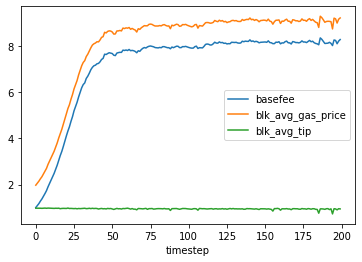

In [10]:
df.plot("timestep", ["basefee", "blk_avg_gas_price", "blk_avg_tip"])

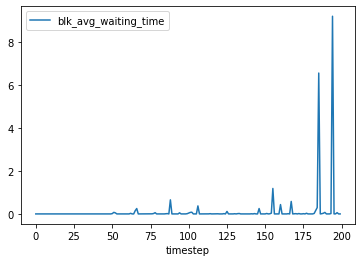

In [11]:
df.plot("timestep", "blk_avg_waiting_time")

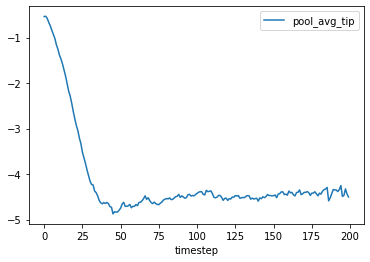

In [12]:
df.plot("timestep", "pool_avg_tip")

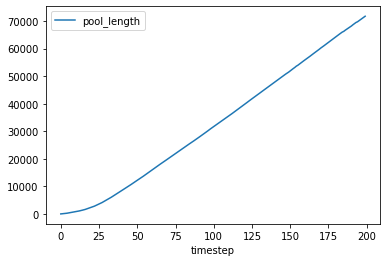

In [13]:
df.plot("timestep", "pool_length")